In [ ]:
#This is a general classifcation template. The data used here is binary.. 

#this model was with Sazara dataset

#more data, more for training, less for vcal, less for test
#splitfolders Alldata --fixed 2000 1000 --oversample


In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn import metrics
import math
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

#Set GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TF version: 2.13.1


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [3]:
#build data generators for training and validaton

# Define dirs and files
train_data_dir = '../Mar2025/output/train'
val_data_dir = '../Mar2025/output/val'
test_data_dir = '../Mar2025/output/test'

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale =1./255.,
                                   rotation_range = 90,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.5,
                                   shear_range = 0.45,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True)


val_datagen = ImageDataGenerator(rescale =1./255.)
test_datagen = ImageDataGenerator(rescale =1./255.)


#set batch Size
batch_size = 16

#set Image size (RGB so imshape is 3)
pix_dim = 224
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    target_size = imsize)

# Flow validation images in batches 
validation_generator =  val_datagen.flow_from_directory(val_data_dir, 
                                                        batch_size = batch_size,
                                                        class_mode = 'categorical',
                                                        target_size = imsize)
# Flow test images in batches 
test_generator =  test_datagen.flow_from_directory(test_data_dir, 
                                                        batch_size = batch_size,
                                                        class_mode = 'categorical',
                                                        target_size = imsize)

Found 13154 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [4]:
#load or build model
##########

#base model, no top layer, w/ imagenet weights
base_model = tf.keras.applications.MobileNetV2(input_shape = imshape, 
                                             include_top = False, 
                                             weights = 'imagenet')

base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [5]:
#load or build model
##########

#base model, no top layer, w/ imagenet weights
base_model = tf.keras.applications.MobileNetV2(input_shape = imshape, 
                                             include_top = False, 
                                             weights = 'imagenet')

base_model.trainable = False
# add a new classifcation layer

final_layer = base_model.get_layer('out_relu')
print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output


#add the last layer
# Flatten the output layer to 1 dimension
x = layers.GlobalAveragePooling2D()(final_base_output )
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-4))(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# # Add a fully connected layer with 512 hidden units and ReLU activation
# x = layers.Dense(512, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-4))(x)
# # Add a dropout rate of 0.5
# x = layers.Dropout(0.5)(x)           
# traditioanlly this owuld be a final sigmoid layer for classification, 
# but we are runnign this as a cat model b/c of TF lite micro limitations..
x = layers.Dense(2,activation = "softmax")(x)       

model = Model(base_model.input, x) 
#############
model.summary()

shape of last layer is  (None, 7, 7, 1280)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)  

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [6]:
# define the metrics
acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')
TP = tf.keras.metrics.TruePositives()
TN = tf.keras.metrics.TrueNegatives()
FP = tf.keras.metrics.FalsePositives()
FN = tf.keras.metrics.FalseNegatives()


In [7]:
#build the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr = 3e-4),
              metrics = [acc_metric, TP, TN, FP, FN])

In [8]:
# define a callback

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'loss', 
                                             patience = 20, 
                                             restore_best_weights = True)

In [9]:
#train the model
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    workers = 24,
                    max_queue_size = 30,
                    epochs= 30,
                    callbacks =[callbacks])

Epoch 1/30
823/823 [==============================] - 113s 131ms/step - loss: 0.5465 - acc: 0.7923 - true_positives: 10422.0000 - true_negatives: 10422.0000 - false_positives: 2732.0000 - false_negatives: 2732.0000 - val_loss: 0.3009 - val_acc: 0.9080 - val_true_positives: 3632.0000 - val_true_negatives: 3632.0000 - val_false_positives: 368.0000 - val_false_negatives: 368.0000
Epoch 2/30
823/823 [==============================] - 112s 135ms/step - loss: 0.4263 - acc: 0.8272 - true_positives: 10881.0000 - true_negatives: 10881.0000 - false_positives: 2273.0000 - false_negatives: 2273.0000 - val_loss: 0.2932 - val_acc: 0.9150 - val_true_positives: 3660.0000 - val_true_negatives: 3660.0000 - val_false_positives: 340.0000 - val_false_negatives: 340.0000
Epoch 3/30
823/823 [==============================] - 112s 132ms/step - loss: 0.4005 - acc: 0.8383 - true_positives: 11027.0000 - true_negatives: 11027.0000 - false_positives: 2127.0000 - false_negatives: 2127.0000 - val_loss: 0.2733 - val_

823/823 [==============================] - 109s 129ms/step - loss: 0.3318 - acc: 0.8724 - true_positives: 11476.0000 - true_negatives: 11476.0000 - false_positives: 1678.0000 - false_negatives: 1678.0000 - val_loss: 0.2396 - val_acc: 0.9222 - val_true_positives: 3689.0000 - val_true_negatives: 3689.0000 - val_false_positives: 311.0000 - val_false_negatives: 311.0000
Epoch 23/30
823/823 [==============================] - 108s 127ms/step - loss: 0.3336 - acc: 0.8696 - true_positives: 11439.0000 - true_negatives: 11439.0000 - false_positives: 1715.0000 - false_negatives: 1715.0000 - val_loss: 0.2498 - val_acc: 0.9200 - val_true_positives: 3680.0000 - val_true_negatives: 3680.0000 - val_false_positives: 320.0000 - val_false_negatives: 320.0000
Epoch 24/30
823/823 [==============================] - 121s 140ms/step - loss: 0.3369 - acc: 0.8657 - true_positives: 11388.0000 - true_negatives: 11388.0000 - false_positives: 1766.0000 - false_negatives: 1766.0000 - val_loss: 0.2435 - val_acc: 0.91

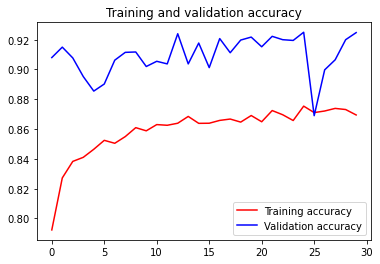

<Figure size 432x288 with 0 Axes>

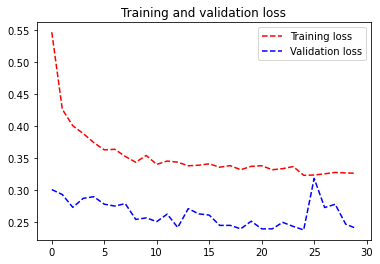

<Figure size 432x288 with 0 Axes>

In [10]:
#look at the metrics from training
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

In [11]:
#save the model
filepath = './models/MNv2Flood_cat_Mar2025'
model.save(filepath)

#load model
#model = tf.keras.models.load_model(filepath, compile = True)

INFO:tensorflow:Assets written to: ./models/MNv2Flood_cat_Mar2025/assets


INFO:tensorflow:Assets written to: ./models/MNv2Flood_cat_Mar2025/assets


In [12]:
#model.evaluate(test_generator)

In [13]:

NF = 0  # Not Flooded count
F = 0   # Flooded count
imsize = (224, 224)  # Assuming the target size of the image, adjust accordingly

# Loop through the images in the 'flooded' folder
for filename in os.listdir('../Mar2025/output/test/flooded/'):
    fp = os.path.join('../Mar2025/output/test/flooded/', filename)
    #print(f"Processing {filename}...")
    
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(fp, target_size=imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize the image
    test_im = np.expand_dims(img, axis=0)  # Add batch dimension

    # Get model predictions
    score = model.predict(test_im, verbose=0)
    print(score)

    # Process the output using argmax to determine the predicted class
    predicted_class = np.argmax(score)
    
    if predicted_class == 1:
        #print('Not Flooded')
        print(f"wrong: {filename}...")
        NF += 1
    else:
        #print('Flooded')
        F += 1

# Print final counts
print(f"True Flood: {F}")
print(f"False Nonflood: {NF}")

[[9.999937e-01 6.359174e-06]]
[[9.9999905e-01 9.2541330e-07]]
[[0.9666617  0.03333831]]
[[0.9982547  0.00174526]]
[[9.9999917e-01 7.8163868e-07]]
[[0.99877995 0.00122003]]
[[9.9999964e-01 3.9870622e-07]]
[[9.999012e-01 9.881068e-05]]
[[0.07125714 0.9287429 ]]
wrong: CAM_BF_01_20220519024221.jpg...
[[0.7669341 0.2330659]]
[[9.993248e-01 6.752718e-04]]
[[9.9999988e-01 1.2443518e-07]]
[[0.9988236  0.00117641]]
[[0.7743485  0.22565149]]
[[9.9969065e-01 3.0932587e-04]]
[[0.49748296 0.50251704]]
wrong: CAM_CB_03_20220616102426.jpg...
[[9.999654e-01 3.451091e-05]]
[[0.52448016 0.4755198 ]]
[[9.9929154e-01 7.0844399e-04]]
[[0.8868012  0.11319883]]
[[0.14822134 0.8517787 ]]
wrong: 1731942367NoFlood.jpg...
[[0.76302356 0.23697646]]
[[0.73159206 0.26840797]]
[[0.9986644  0.00133561]]
[[9.9999964e-01 3.5524457e-07]]
[[0.99632347 0.00367656]]
[[9.9990630e-01 9.3739196e-05]]
[[1.0000000e+00 1.2579684e-11]]
[[9.999907e-01 9.247497e-06]]
[[9.9976248e-01 2.3750344e-04]]
[[9.9999785e-01 2.1977460e-06]]


[[9.9975878e-01 2.4123325e-04]]
[[9.996356e-01 3.644476e-04]]
[[0.9975303  0.00246974]]
[[9.9999464e-01 5.3253571e-06]]
[[9.99708e-01 2.91976e-04]]
[[9.9900335e-01 9.9661760e-04]]
[[9.9968219e-01 3.1779008e-04]]
[[1.0000000e+00 1.1068144e-08]]
[[0.9979674 0.0020326]]
[[0.56389457 0.4361055 ]]
[[9.999223e-01 7.774164e-05]]
[[9.9998367e-01 1.6389738e-05]]
[[0.57310206 0.4268979 ]]
[[0.14375055 0.85624945]]
wrong: Flood_1098.jpg...
[[0.9985586  0.00144143]]
[[1.000000e+00 1.519532e-10]]
[[9.9999964e-01 3.5133661e-07]]
[[9.9999964e-01 4.0535161e-07]]
[[0.9264412  0.07355886]]
[[0.99793124 0.00206875]]
[[0.6399948  0.36000517]]
[[0.9197647  0.08023532]]
[[0.9917276  0.00827245]]
[[0.55966574 0.44033423]]
[[9.9999964e-01 3.4291884e-07]]
[[0.99853504 0.00146491]]
[[9.9918932e-01 8.1064686e-04]]
[[0.5256484  0.47435158]]
[[0.7566403  0.24335971]]
[[9.999784e-01 2.152728e-05]]
[[0.9175435 0.0824565]]
[[9.9995232e-01 4.7740523e-05]]
[[9.999951e-01 4.941549e-06]]
[[9.9942386e-01 5.7617936e-04]]
[

[[9.999713e-01 2.875301e-05]]
[[1.000000e+00 1.879839e-10]]
[[0.9889815  0.01101854]]
[[0.5625016 0.4374984]]
[[0.98314923 0.01685071]]
[[9.9920255e-01 7.9752191e-04]]
[[9.996170e-01 3.830292e-04]]
[[9.9995935e-01 4.0611070e-05]]
[[0.99224174 0.0077583 ]]
[[0.08018611 0.9198139 ]]
wrong: 1724345287Flood.jpg...
[[9.9999475e-01 5.2863147e-06]]
[[0.99533963 0.00466032]]
[[0.77676 0.22324]]
[[0.0497428 0.9502572]]
wrong: CAM_CB_01_20220613133022.jpg...
[[9.9984419e-01 1.5575823e-04]]
[[9.9999976e-01 2.3377385e-07]]
[[9.9964178e-01 3.5818762e-04]]
[[1.0000000e+00 1.1891134e-08]]
[[9.999796e-01 2.032500e-05]]
[[9.9989748e-01 1.0246611e-04]]
[[9.999926e-01 7.428404e-06]]
[[1.00000e+00 7.65696e-09]]
[[0.516404 0.483596]]
[[0.6626664  0.33733365]]
[[0.99692565 0.00307433]]
[[1.0000000e+00 2.0260233e-09]]
[[9.999999e-01 9.518110e-08]]
[[9.9995935e-01 4.0703275e-05]]
[[9.9952292e-01 4.7706492e-04]]
[[9.9999964e-01 3.7497728e-07]]
[[9.9999964e-01 3.7731468e-07]]
[[9.999149e-01 8.505498e-05]]
[[9.9

[[0.70829594 0.29170403]]
[[9.9927813e-01 7.2186644e-04]]
[[9.9998772e-01 1.2264606e-05]]
[[9.9999762e-01 2.3341527e-06]]
[[0.9971244  0.00287561]]
[[9.9999094e-01 9.0803887e-06]]
[[9.9999988e-01 1.6966476e-07]]
[[9.9999988e-01 1.4032877e-07]]
[[9.9985802e-01 1.4191857e-04]]
[[1.0000000e+00 1.9240643e-08]]
[[9.9993134e-01 6.8615096e-05]]
[[9.9968636e-01 3.1368283e-04]]
[[9.9996901e-01 3.0948653e-05]]
[[9.9984324e-01 1.5668386e-04]]
[[9.999994e-01 6.061179e-07]]
[[9.9941576e-01 5.8429816e-04]]
[[9.999999e-01 8.860356e-08]]
[[0.67653126 0.32346871]]
[[0.7199185  0.28008154]]
[[0.99789524 0.00210478]]
[[0.4889835 0.5110165]]
wrong: 1731873246Flood.jpg...
[[1.000000e+00 2.021188e-08]]
[[0.50171787 0.49828213]]
[[0.5502083  0.44979176]]
[[9.9984944e-01 1.5058307e-04]]
[[0.8668605  0.13313949]]
[[1.000000e+00 5.312392e-11]]
[[0.99805117 0.00194885]]
[[1.0000000e+00 1.8161181e-10]]
[[0.76973504 0.23026499]]
[[9.9971718e-01 2.8280576e-04]]
[[9.9985003e-01 1.4990312e-04]]
[[0.94781154 0.0521884

In [14]:

NF = 0  # Not Flooded count
F = 0   # Flooded count
imsize = (224, 224)  # Assuming the target size of the image, adjust accordingly

# Loop through the images in the 'flooded' folder
for filename in os.listdir('../Mar2025/output/test/not_flooded/'):
    fp = os.path.join('../Mar2025/output/test/not_flooded/', filename)
    #print(f"Processing {filename}...")
    
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(fp, target_size=imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize the image
    test_im = np.expand_dims(img, axis=0)  # Add batch dimension

    # Get model predictions
    score = model.predict(test_im, verbose=0)
    print(score)

    # Process the output using argmax to determine the predicted class
    predicted_class = np.argmax(score)
    
    if predicted_class == 1:
        #print('Not Flooded')
        NF += 1
    else:
        #print('Flooded')
        print(f"wrong: {filename}...")
        F += 1

# Print final counts
print(f"False Flood: {F}")
print(f"True Nonflood: {NF}")

[[0.00870457 0.99129546]]
[[0.2110562  0.78894377]]
[[0.2402368  0.75976324]]
[[0.03283392 0.9671661 ]]
[[0.00163712 0.99836284]]
[[0.1316011  0.86839885]]
[[0.00243872 0.99756134]]
[[0.03754915 0.96245086]]
[[0.0118272 0.9881728]]
[[9.9664752e-04 9.9900335e-01]]
[[0.00879951 0.9912005 ]]
[[0.03611902 0.96388096]]
[[0.4586485  0.54135156]]
[[0.34771046 0.65228957]]
[[0.00252965 0.9974704 ]]
[[0.38500658 0.6149934 ]]
[[0.11515845 0.8848416 ]]
[[0.46244532 0.5375546 ]]
[[0.22643873 0.77356124]]
[[0.03801317 0.96198684]]
[[0.339939 0.660061]]
[[0.2785981  0.72140193]]
[[0.39434162 0.6056584 ]]
[[0.0784063 0.9215937]]
[[0.02554446 0.9744555 ]]
[[0.6745464 0.3254536]]
wrong: CAM_CB_03_20220612054831.jpg...
[[0.01937645 0.98062354]]
[[0.36160025 0.6383997 ]]
[[0.20909083 0.7909092 ]]
[[0.16231978 0.83768016]]
[[0.3821206  0.61787933]]
[[0.02923673 0.97076327]]
[[0.00159045 0.99840957]]
[[0.41960672 0.58039325]]
[[0.3778875  0.62211245]]
[[0.03129935 0.9687007 ]]
[[0.13117763 0.86882234]]
[[0

[[0.4622147 0.5377853]]
[[0.06992819 0.93007183]]
[[0.00617816 0.99382186]]
[[0.00581504 0.99418503]]
[[0.02953402 0.97046596]]
[[0.15450923 0.8454908 ]]
[[0.01569133 0.98430866]]
[[0.02745128 0.9725487 ]]
[[0.00299536 0.9970047 ]]
[[0.10928912 0.8907109 ]]
[[0.04387945 0.95612055]]
[[0.00693748 0.99306256]]
[[0.20153695 0.79846305]]
[[0.12440081 0.8755992 ]]
[[0.00314568 0.99685436]]
[[0.08720669 0.91279334]]
[[0.42388225 0.5761177 ]]
[[0.18274525 0.8172548 ]]
[[0.05032412 0.9496759 ]]
[[0.22071053 0.7792894 ]]
[[0.3360934  0.66390663]]
[[0.52706677 0.47293323]]
wrong: CAM_CB_03_20220616002426.jpg...
[[0.05760667 0.94239336]]
[[0.22893314 0.7710669 ]]
[[0.03359277 0.96640724]]
[[0.12024088 0.87975913]]
[[0.28765467 0.7123453 ]]
[[0.14421298 0.855787  ]]
[[0.01999689 0.9800031 ]]
[[0.4073471  0.59265286]]
[[0.06447659 0.9355234 ]]
[[0.00292235 0.9970777 ]]
[[0.00198224 0.9980178 ]]
[[0.0072742  0.99272573]]
[[0.07212171 0.92787826]]
[[0.4926722  0.50732785]]
[[0.16728166 0.8327183 ]]
[

[[0.08768381 0.9123162 ]]
[[0.22075717 0.7792428 ]]
[[0.49281773 0.50718224]]
[[0.01075759 0.9892424 ]]
[[0.33616084 0.6638392 ]]
[[0.00112077 0.99887925]]
[[0.2593134  0.74068666]]
[[0.02126317 0.97873676]]
[[0.0024486 0.9975514]]
[[0.04068275 0.95931727]]
[[0.00178918 0.9982108 ]]
[[0.06438882 0.93561125]]
[[0.28194994 0.71805   ]]
[[0.01145072 0.9885493 ]]
[[0.22598343 0.77401656]]
[[0.10282147 0.8971786 ]]
[[0.47193038 0.5280696 ]]
[[0.28380206 0.7161979 ]]
[[0.45222902 0.54777104]]
[[0.05265198 0.94734806]]
[[0.06224731 0.9377527 ]]
[[0.09553698 0.90446305]]
[[0.19775762 0.80224234]]
[[0.2934901 0.7065099]]
[[0.38586888 0.6141311 ]]
[[0.00251234 0.99748766]]
[[0.18924734 0.81075263]]
[[0.00230002 0.99770004]]
[[0.00428639 0.9957136 ]]
[[0.14249085 0.85750914]]
[[0.1425145  0.85748553]]
[[0.00775304 0.992247  ]]
[[0.00102182 0.99897826]]
[[0.00999476 0.9900052 ]]
[[0.04681412 0.9531859 ]]
[[0.49826115 0.50173885]]
[[0.02937498 0.970625  ]]
[[0.5441622  0.45583782]]
wrong: CAM_CB_03

[[0.04832006 0.95168   ]]
[[0.00165259 0.9983474 ]]
[[0.06560645 0.9343936 ]]
[[0.12451015 0.8754899 ]]
[[0.00356289 0.9964371 ]]
[[0.00100269 0.9989973 ]]
[[0.19938955 0.8006104 ]]
[[0.14002317 0.8599768 ]]
[[0.03419425 0.9658057 ]]
[[0.19558778 0.8044122 ]]
[[0.1654791 0.8345209]]
[[4.0072872e-04 9.9959928e-01]]
[[0.03366375 0.9663362 ]]
[[0.0024946  0.99750537]]
[[0.00123094 0.998769  ]]
[[0.30456635 0.6954336 ]]
[[0.5077396 0.4922604]]
wrong: CAM_CB_03_20220612000626.jpg...
[[0.562088   0.43791196]]
wrong: CAM_CB_03_20220612085434.jpg...
[[0.00282791 0.9971722 ]]
[[0.28987497 0.710125  ]]
[[0.00175433 0.9982457 ]]
[[0.04771322 0.9522867 ]]
[[0.0149073 0.9850927]]
[[4.3563970e-04 9.9956435e-01]]
[[7.2373863e-04 9.9927622e-01]]
[[0.06232286 0.93767715]]
[[0.4073743  0.59262574]]
[[0.11417633 0.8858236 ]]
[[0.18701835 0.81298167]]
[[0.28523043 0.71476954]]
[[0.00275051 0.9972494 ]]
[[0.00152845 0.99847156]]
[[0.03057542 0.96942455]]
[[0.02294521 0.9770547 ]]
[[0.00256925 0.99743074]]


[[913  87]
 [ 46 954]]


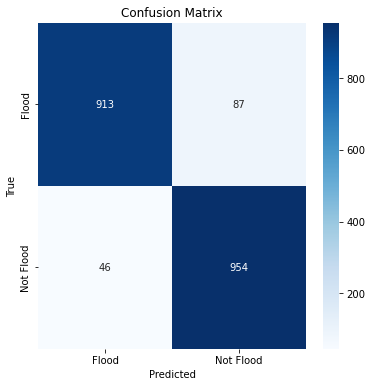

              precision    recall  f1-score   support

       Flood       0.95      0.91      0.93      1000
   Not Flood       0.92      0.95      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



In [15]:

# Define the directories for 'flood' and 'not_flood'
test_dir = '../Mar2025/output/test/'  # Adjust as needed
flood_dir = os.path.join(test_dir, 'flooded')
not_flood_dir = os.path.join(test_dir, 'not_flooded')

# Assuming the image size is (224, 224), adjust accordingly
imsize = (224, 224)

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Helper function to preprocess an image
def preprocess_image(filepath):
    img = tf.keras.preprocessing.image.load_img(filepath, target_size=imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Process 'flood' folder (class 0)
for filename in os.listdir(flood_dir):
    filepath = os.path.join(flood_dir, filename)
    img = preprocess_image(filepath)

    # Predict with the model
    prediction = model.predict(img, verbose=0)
    predicted_class = np.argmax(prediction)  # Assuming softmax output

    # Append the results
    true_labels.append(0)  # Class 0 for 'flood'
    predicted_labels.append(predicted_class)

# Process 'not_flood' folder (class 1)
for filename in os.listdir(not_flood_dir):
    filepath = os.path.join(not_flood_dir, filename)
    img = preprocess_image(filepath)

    # Predict with the model
    prediction = model.predict(img, verbose=0)
    predicted_class = np.argmax(prediction)  # Assuming softmax output

    # Append the results
    true_labels.append(1)  # Class 1 for 'not_flood'
    predicted_labels.append(predicted_class)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

# Display confusion matrix using Seaborn
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Flood', 'Not Flood'], yticklabels=['Flood', 'Not Flood'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Optionally print a classification report
print(classification_report(true_labels, predicted_labels, target_names=['Flood', 'Not Flood']))

In [16]:
##Quantize model

In [17]:
# Define the number of calibration steps based on batch size and number of samples to use
num_calibration_steps = 50  # Adjust this based on how many samples you want to use for calibration

# model is already defined and trained
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Representative dataset function for calibration
def representative_dataset_gen():
    for i in range(num_calibration_steps):
        x = validation_generator.next()[0]  # one batch or single image
        yield [x.astype(np.float32)]  # ensure float32

converter.representative_dataset = representative_dataset_gen

# Set supported ops and inference types to int8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # Quantized model inputs to int8
converter.inference_output_type = tf.int8  # Quantized model outputs to int8

# Convert the model
tflite_model = converter.convert()

# Save the quantized model
with open('MNv2Flood_cat_Mar2025.tflite', 'wb') as f:
    f.write(tflite_model)

# Load the quantized model to check input/output types
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Check input/output types
input_type = interpreter.get_input_details()[0]['dtype']
output_type = interpreter.get_output_details()[0]['dtype']
print('Input dtype: ', input_type)
print('Output dtype: ', output_type)

INFO:tensorflow:Assets written to: /tmp/tmp49rx_n8s/assets


INFO:tensorflow:Assets written to: /tmp/tmp49rx_n8s/assets
/usr/lib/python3/dist-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Input dtype:  <class 'numpy.int8'>
Output dtype:  <class 'numpy.int8'>


2025-03-24 12:15:04.745255: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-03-24 12:15:04.745291: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


[[905  95]
 [195 805]]


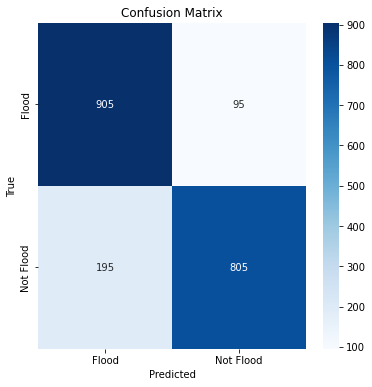

              precision    recall  f1-score   support

       Flood       0.82      0.91      0.86      1000
   Not Flood       0.89      0.81      0.85      1000

    accuracy                           0.85      2000
   macro avg       0.86      0.85      0.85      2000
weighted avg       0.86      0.85      0.85      2000



In [18]:

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="MNv2Flood_cat_Mar2025.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get input and output shapes and types
input_shape = input_details[0]['shape']
input_dtype = input_details[0]['dtype']  # Expecting int8 or uint8
output_dtype = output_details[0]['dtype']

# Define the directories for 'flood' and 'not_flood'
test_dir = '../Mar2025/output/test/'  # Adjust as needed
flood_dir = os.path.join(test_dir, 'flooded')
not_flood_dir = os.path.join(test_dir, 'not_flooded')

# Assuming the image size is (224, 224), adjust accordingly
imsize = (224, 224)


# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Helper function to preprocess an image for the quantized model
def preprocess_image(filepath):
    img = tf.keras.preprocessing.image.load_img(filepath, target_size=imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    # Normalize to match the quantized model input (int8 or uint8)
    img = img / 255.0  # Normalize the image to [0,1]
    
    if input_dtype == np.uint8:
        img = (img * 255).astype(np.uint8)  # For uint8, scale to [0, 255]
    elif input_dtype == np.int8:
        img = (img * 127.0).astype(np.int8)  # For int8, scale to [-128, 127]
    
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to make predictions with the TensorFlow Lite interpreter
def predict_with_interpreter(image):
    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], image)

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # Use argmax to get the predicted class (assuming two classes)
    predicted_class = np.argmax(output_data)
    return predicted_class

# Process 'flood' folder (class 0)
for filename in os.listdir(flood_dir):
    filepath = os.path.join(flood_dir, filename)
    img = preprocess_image(filepath)

    # Predict with the interpreter
    predicted_class = predict_with_interpreter(img)

    # Append the results
    true_labels.append(0)  # Class 0 for 'flood'
    predicted_labels.append(predicted_class)

# Process 'not_flood' folder (class 1)
for filename in os.listdir(not_flood_dir):
    filepath = os.path.join(not_flood_dir, filename)
    img = preprocess_image(filepath)

    # Predict with the interpreter
    predicted_class = predict_with_interpreter(img)

    # Append the results
    true_labels.append(1)  # Class 1 for 'not_flood'
    predicted_labels.append(predicted_class)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

# Display confusion matrix using Seaborn
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Flood', 'Not Flood'], yticklabels=['Flood', 'Not Flood'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Optionally print a classification report
print(classification_report(true_labels, predicted_labels, target_names=['Flood', 'Not Flood']))